Plotting a dendrogram & trying out PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from scipy.cluster.hierarchy import dendrogram, linkage 
from semcor_bert_utils import *

In [2]:
sparsity_ranks = pd.read_csv('../data/semcor_sparsity.csv')
sparsity_ranks.iloc[:20]

,word,pos,freq_sd,senses_for_pos
0,be,v,2753.646765,8
1,have,v,341.328009,6
2,do,v,214.057214,2
3,make,v,176.710568,8
4,see,v,128.110418,13
5,get,v,109.046114,5
6,come,v,104.112211,6
7,give,v,80.185312,11
8,go,v,77.299226,5
9,show,v,62.752327,2


In [3]:
model = initialize_model()

In [4]:
place_embeds, place_labels = run_pipeline('place', 'n', model)

Getting data from SEMCOR
Senses for word place
Getting sentences for relevant senses
Number of sentences for sense ('n', '01') 57
Number of sentences for sense ('n', '03') 17
Number of sentences for sense ('n', '02') 31
Generating BERT embeddings


In [8]:
def plot_dendrogram(embeds, labels, color_dict, label_dict, word_pos):
    embeds = [v.numpy() for v in embeds]
    Z = linkage(embeds, method = 'single', metric = 'cosine')
    plt.figure(figsize = (20, 8))
    dendrogram(Z, labels = labels, link_color_func=lambda k: 'gray')

    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(color_dict[lbl.get_text()])
    
    leg_patches = [mpatches.Patch(color = label_dict[i]['color'],
                                  label = label_dict[i]['label']) for i in np.arange(len(label_dict))]
    plt.legend(handles=leg_patches)
    plt.title("Nearest Neighbor Dendrogram for BERT Embeddings of " + word_pos + " in SEMCOR")


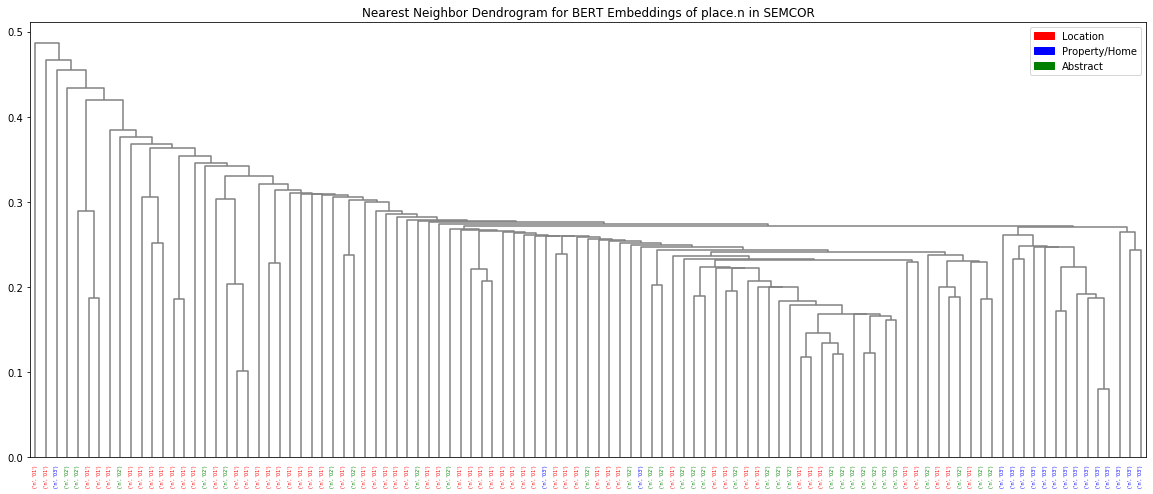

In [10]:
plot_dendrogram(place_embeds, place_labels, {"('n', '01')": 'r', "('n', '02')": 'g', "('n', '03')": 'b'},
               {0:{'color': 'r', 'label': 'Location'}, 1: {'color': 'b', 'label': 'Property/Home'},
               2: {'color': 'g', 'label': 'Abstract'}}, 'place.n')

In [11]:
from sklearn.decomposition import PCA

In [14]:
place_embeds = np.array([v.numpy() for v in place_embeds])

10 principle components explain 73.5% of the variance.

In [15]:
transposed_place = np.transpose(place_embeds)
test_pca = PCA(n_components = 10)
pca_embeds = test_pca.fit(transposed_place).components_
sum(test_pca.explained_variance_ratio_)

0.735107259824872

In [48]:
recode_label = lambda s: int(s[1]) - 1
true_labels = [recode_label(l) for l in place_labels]


In [83]:
ev_ratios = []
gmm_gt_means = []
gmm_gt_sds = []
gmm_random_means = []
gmm_random_sds = []

n_comps = range(2, 60)
for c in n_comps:
    pca = PCA(n_components = c)
    pca.fit(transposed_place)
    ev_ratios.append(sum(pca.explained_variance_ratio_))
    results = gmm_rand(pca.components_.T, true_labels)
    gmm_gt_means.append(results['GMM'][0])
    gmm_gt_sds.append(results['GMM'][1])
    gmm_random_means.append(results['Random'][0])
    gmm_random_sds.append(results['Random'][1])

Text(0.5, 1.0, 'PCA on BERT embeddings of place.n')

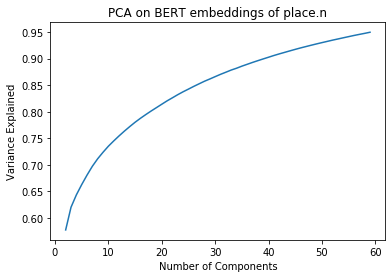

In [84]:
plt.plot(n_comps, ev_ratios)
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.title("PCA on BERT embeddings of place.n")



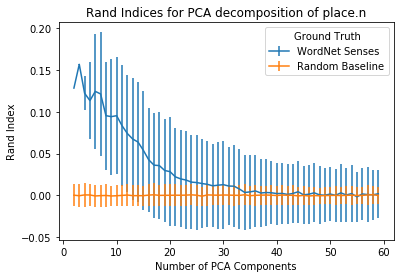

In [86]:
plt.errorbar(n_comps, gmm_gt_means, yerr = gmm_gt_sds, label = "WordNet Senses")
plt.errorbar(n_comps, gmm_random_means, yerr = gmm_random_sds, label = "Random Baseline")
plt.xlabel("Number of PCA Components")
plt.ylabel("Rand Index")
plt.title("Rand Indices for PCA decomposition of place.n")
plt.legend(title = 'Ground Truth')


Text(0, 0.5, 'Average Rand Index with 1000 GMMs')

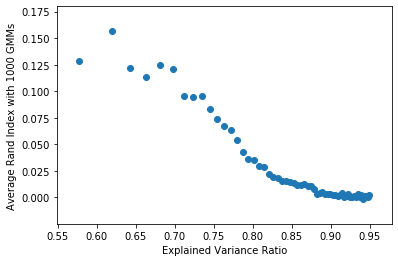

In [89]:
plt.scatter(ev_ratios, gmm_gt_means)
plt.xlabel("Explained Variance Ratio")
plt.ylabel("Average Rand Index with 1000 GMMs")

In [65]:
import sklearn.mixture
from sklearn.metrics import adjusted_rand_score

In [29]:
dpgmm = sklearn.mixture.BayesianGaussianMixture(n_components = 3)

In [30]:
test_pca.components_.T.shape

(105, 10)

In [42]:
recode_label = lambda s: int(s[1]) - 1
true_labels = [recode_label(l) for l in place_labels]


In [73]:
gmm_rand(test_pca.components_.T, true_labels)

{'GMM': [0.09457273091967475, 0.07052145780447742],
 'Random': [-0.0005761316661795151, 0.012375447377076772]}